In [112]:
import seg_metrics.seg_metrics as sg
import pandas as pd
import numpy as np
import nibabel as nib
import os
import pydicom
from skimage import morphology
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import cv2
from skimage.morphology import skeletonize, skeletonize_3d

In [33]:
def icc(Y, icc_type='ICC(2,1)'):
    ''' Calculate intraclass correlation coefficient

    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''

    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

In [77]:
def cl_score(v, s):
    """[this function computes the skeleton volume overlap]
    Args:
        v ([bool]): [image]
        s ([bool]): [skeleton]
    Returns:
        [float]: [computed skeleton volume intersection]
    """
    return np.sum(v*s)/np.sum(s)


def clDice(v_p, v_l):
    """[this function computes the cldice metric]
    Args:
        v_p ([bool]): [predicted image]
        v_l ([bool]): [ground truth image]
    Returns:
        [float]: [cldice metric]
    """
    if len(v_p.shape)==2:
        tprec = cl_score(v_p,skeletonize(v_l))
        tsens = cl_score(v_l,skeletonize(v_p))
    elif len(v_p.shape)==3:
        tprec = cl_score(v_p,skeletonize_3d(v_l))
        tsens = cl_score(v_l,skeletonize_3d(v_p))
    return 2*tprec*tsens/(tprec+tsens)

In [106]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

In [99]:
def get_scores(metrics_df, dir_gt, dir_pred):
    volumes_gt = []
    volumes_pred = []
    clDSCs = []
    for filename in metrics_df.filename:
        item = os.path.split(filename)[-1]
        filename_gt = os.path.join(dir_gt,item)
        filename_pred = os.path.join(dir_pred,item)
        nii_gt = nib.load(filename_gt)
        nii_pred = nib.load(filename_pred)
        array_gt = nii_gt.get_fdata()
        array_pred = nii_pred.get_fdata()
        volume_gt = np.sum(array_gt>0)
        volume_pred = np.sum(array_pred)
        clDSCs.append(clDice(array_gt, array_pred)) 
        volumes_gt.append(volume_gt)
        volumes_pred.append(volume_pred)
    metrics_df['volume_gt'] = volumes_gt
    metrics_df['volume_pred'] = volumes_pred
    metrics_df['volume_error'] = np.abs(np.array(volumes_gt) - np.array(volumes_pred))
    metrics_df['clDice'] = clDSCs

    icc_score = icc(np.column_stack((volumes_gt, volumes_pred)), icc_type='ICC(2,k)')
    
    scores_median = metrics_df[scorenames].median()
    scores_median['icc'] = icc_score
    
    Q1 = metrics_df[scorenames].quantile(0.25)
    Q3 = metrics_df[scorenames].quantile(0.75)
    scores_iqr = Q3 - Q1
    
    return scores_median, scores_iqr

In [127]:
def calculate_area_diameter(mask):
    mask_labeled = label(mask)
    regions = regionprops(mask_labeled)
    area_max = 0
    diameter_max = 0
    for r in regions:
        diameter = r.axis_major_length
        area = r.area
        if area>area_max:
            area_max = area
            diameter_max = diameter
    return area_max, diameter_max

In [100]:
def dirname2scores(dirname_gt, dirname_pred, filename_metrics):
    metrics = sg.write_metrics(labels=[1], gdth_path=dirname_gt, pred_path=dirname_pred, csv_file=filename_metrics)
    metrics_dataframe = pd.read_csv(filename_metrics)
    scores_median, scores_iqr = get_scores(metrics_dataframe, dirname_gt, dirname_pred)
    return scores_median, scores_iqr, metrics_dataframe

In [101]:
scorenames = ['dice','jaccard','precision','recall','fpr','fnr','vs','hd','msd','mdsd','stdsd','hd95','volume_error','clDice']

In [151]:
def get_2Dscores(metrics_df, dir_gt, dir_pred):
    areas = []
    diameters = []
    dscs = []
    for filename in metrics_df.filename:
        item = os.path.split(filename)[-1]
        filename_gt = os.path.join(dir_gt,item)
        filename_pred = os.path.join(dir_pred,item)
        nii_gt = nib.load(filename_gt)
        nii_pred = nib.load(filename_pred)
        array_gt = nii_gt.get_fdata()
        array_pred = nii_pred.get_fdata()
        for i in range(array_gt.shape[2]):
            dsc = calculate_dice(array_gt[..., i], array_pred[..., i])
            a, d = calculate_area_diameter(array_gt[..., i])
            areas.append(a*0.303030*0.303030)
            diameters.append(d)
            dscs.append(dsc)
    return areas, diameters, dscs
            

## nnUNet

In [102]:
nifti_dirname_GT = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc_GT"

nifti_dirname_test = r"D:\Lisa\nnUNet_raw_data_base\nnUNet_results\Ts1"
nifti_dirname_t2w = r"D:\Lisa\nnUNet_raw_data_base\nnUNet_results\Ts2"
nifti_dirname_t1wce = r"D:\Lisa\nnUNet_raw_data_base\nnUNet_results\Ts3"
nifti_dirname_emc = r"D:\Lisa\nnUNet_raw_data_base\nnUNet_results\Ts4"

In [103]:
scores_median_test, scores_iqr_test, scores_df_test = dirname2scores(nifti_dirname_GT, nifti_dirname_test, 
                                                                     'metrics_nnunet_test.csv')
scores_median_t2w, scores_iqr_t2w, scores_df_t2w = dirname2scores(nifti_dirname_GT, nifti_dirname_t2w, 
                                                                  'metrics_nnunet_t2w.csv')
scores_median_t1wce, scores_iqr_t1wce, scores_df_t1wce = dirname2scores(nifti_dirname_GT, nifti_dirname_t1wce, 
                                                                        'metrics_nnunet_t1wce.csv')
scores_median_emc, scores_iqr_emc, scores_df_emc = dirname2scores(nifti_dirname_GT_emc, nifti_dirname_emc, 
                                                                  'metrics_nnunet_emc.csv')

Process UMCU036.nii.gz ...: : 24it [00:16,  1.44it/s]
Process UMCU036.nii.gz ...: : 24it [00:16,  1.48it/s]
Process UMCU036.nii.gz ...: : 24it [00:16,  1.49it/s]
Process EMC057.nii.gz ...: : 34it [00:24,  1.41it/s]
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [104]:
scores_df = pd.concat([scores_median_test, scores_iqr_test, 
                       scores_median_t2w, scores_iqr_t2w, 
                       scores_median_t1wce, scores_iqr_t1wce, 
                       scores_median_emc, scores_iqr_emc], axis=1)
scores_df.columns = ['test (median)', 'test (IQR)', 't2w (median)', 't2w (IQR)', 
                     't1wce (median)', 't1wce (IQR)', 'emc (median)', 'emc (IQR)']
scores_df

,test (median),test (IQR),t2w (median),t2w (IQR),t1wce (median),t1wce (IQR),emc (median),emc (IQR)
dice,0.915515,0.040113,0.892956,0.048952,0.852200,0.111599,0.872578,0.116786
jaccard,0.844221,0.067904,0.806619,0.079300,0.742651,0.166549,0.773968,0.175413
precision,0.926388,0.049276,0.923389,0.091353,0.877488,0.114831,0.979682,0.033746
recall,0.891519,0.096572,0.887612,0.118099,0.847257,0.189222,0.781861,0.157526
fpr,0.000416,0.000312,0.000464,0.000546,0.000748,0.000935,0.000179,0.000261
fnr,0.108481,0.096572,0.112388,0.118099,0.152743,0.189222,0.218138,0.157526
vs,0.069464,0.115188,0.013929,0.196363,0.013119,0.177423,0.213494,0.172096
hd,2.534831,5.266330,3.589805,6.920361,4.373492,9.153235,6.579737,4.415721
msd,0.192148,0.260591,0.310645,0.223993,0.434132,0.649802,0.537144,0.397381
mdsd,0.000000,0.000000,0.000000,0.000000,0.000000,0.075758,0.273449,0.358399


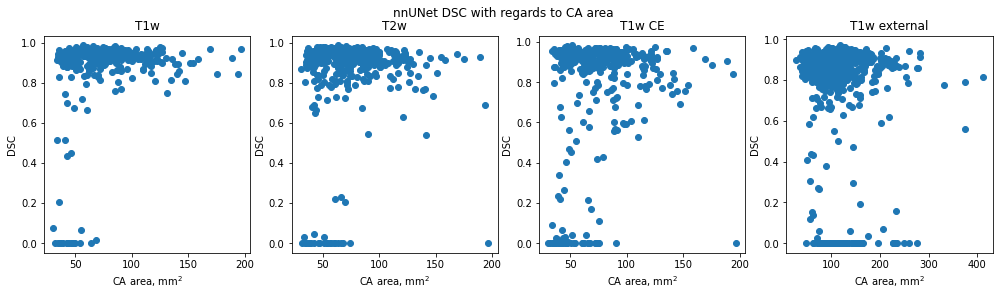

In [155]:
areas_test, diameters_test, dscs_test = get_2Dscores(scores_df_test, nifti_dirname_GT, nifti_dirname_test)
areas_t2w, diameters_t2w, dscs_t2w = get_2Dscores(scores_df_t2w, nifti_dirname_GT, nifti_dirname_t2w)
areas_t1wce, diameters_t1wce, dscs_t1wce = get_2Dscores(scores_df_t1wce, nifti_dirname_GT, nifti_dirname_t1wce)
areas_emc, diameters_emc, dscs_emc = get_2Dscores(scores_df_emc, nifti_dirname_GT_emc, nifti_dirname_emc)

plt.figure(figsize=(17, 4))
plt.subplot(141)
plt.scatter(areas_test, dscs_test)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w')
plt.subplot(142)
plt.scatter(areas_t2w, dscs_t2w)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T2w')
plt.subplot(143)
plt.scatter(areas_t1wce, dscs_t1wce)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w CE')
plt.subplot(144)
plt.scatter(areas_emc, dscs_emc)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w external')
plt.suptitle('nnUNet DSC with regards to CA area')
plt.show()

In [167]:
import pickle

In [168]:
img_1_filename = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test_GT\AMC006.nii.gz"
img_1_nifti = nib.load(img_1_filename)
img_1 = img_1_nifti.get_fdata().T

In [170]:
sm_cropped = np.load(r"D:\Lisa\nnUNet_raw_data_base\nnUNet_results\Ts1\AMC006.npz")['softmax']
with open(r"D:\Lisa\nnUNet_raw_data_base\nnUNet_results\Ts1\AMC006.pkl", 'rb') as f:
    p = pickle.load(f)
    crop_box = p['crop_bbox']
    sm = np.zeros(img_1.shape, dtype=np.float16)
    sm[crop_box[0][0]:crop_box[0][1],crop_box[1][0]:crop_box[1][1],crop_box[2][0]:crop_box[2][1]]=sm_cropped[1, ...]

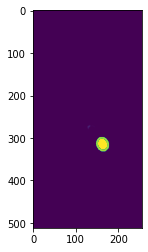

In [175]:
plt.imshow(sm[0, ...])
plt.contour(img_1[0, ...])

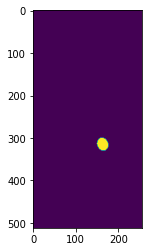

In [174]:
plt.imshow(img_1[0, ...])

In [176]:
np.unique(img_1)

array([0., 1.])

In [177]:
np.unique(sm)

array([0.000e+00, 5.960e-08, 1.192e-07, ..., 9.990e-01, 9.995e-01,
       1.000e+00], dtype=float16)

In [ ]:
plt.imshow(img_1[0, ...])

In [178]:
from sklearn.metrics import brier_score_loss

In [180]:
brier_score_loss(img_1.flatten(), sm.flatten())

0.0013004581624696315

## nnUnet+plaq-u-net_0

In [156]:
nifti_dirname_GT = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc_GT"

nifti_dirname_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test_plaqunet_0"
nifti_dirname_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w_plaqunet_0"
nifti_dirname_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce_plaqunet_0"
nifti_dirname_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc_plaqunet_0"

In [157]:
scores_median_test, scores_iqr_test, scores_df_test = dirname2scores(nifti_dirname_GT, nifti_dirname_test, 
                                                                     'metrics_plaqunet_test.csv')
scores_median_t2w, scores_iqr_t2w, scores_df_t2w = dirname2scores(nifti_dirname_GT, nifti_dirname_t2w, 
                                                                  'metrics_plaqunet_t2w.csv')
scores_median_t1wce, scores_iqr_t1wce, scores_df_t1wce = dirname2scores(nifti_dirname_GT, nifti_dirname_t1wce, 
                                                                        'metrics_nnunet_t1wce.csv')
scores_median_emc, scores_iqr_emc, scores_df_emc = dirname2scores(nifti_dirname_GT_emc, nifti_dirname_emc, 
                                                                  'metrics_plaqunet_emc.csv')

Process UMCU036.nii.gz ...: : 24it [00:16,  1.44it/s]
Process UMCU036.nii.gz ...: : 24it [00:16,  1.42it/s]
Process UMCU036.nii.gz ...: : 24it [00:16,  1.44it/s]
Process EMC057.nii.gz ...: : 34it [00:24,  1.40it/s]
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [158]:
scores_df = pd.concat([scores_median_test, scores_iqr_test, 
                       scores_median_t2w, scores_iqr_t2w, 
                       scores_median_t1wce, scores_iqr_t1wce, 
                       scores_median_emc, scores_iqr_emc
                      ], axis=1)
scores_df.columns = ['test (median)', 'test (IQR)',
                     't2w (median)', 't2w (IQR)', 
                     't1wce (median)', 't1wce (IQR)', 'emc (median)', 'emc (IQR)'
                    ]
scores_df

,test (median),test (IQR),t2w (median),t2w (IQR),t1wce (median),t1wce (IQR),emc (median),emc (IQR)
dice,0.918981,0.049565,0.883187,0.053858,0.846723,0.134140,0.867752,0.091954
jaccard,0.850111,0.082718,0.790853,0.087398,0.734239,0.196620,0.766398,0.140128
precision,0.934899,0.053017,0.902210,0.114515,0.877488,0.150718,0.971845,0.061717
recall,0.881139,0.097286,0.879967,0.131299,0.836988,0.205596,0.779130,0.148214
fpr,0.000389,0.000265,0.000590,0.000663,0.000736,0.001116,0.000232,0.000455
fnr,0.118861,0.097286,0.120033,0.131299,0.163012,0.205596,0.220870,0.148214
vs,0.074665,0.114309,0.011216,0.202993,0.007452,0.191961,0.191117,0.157887
hd,2.278981,1.341168,3.086866,4.923934,4.212434,7.408509,7.088575,4.892117
msd,0.187475,0.219930,0.326324,0.415110,0.473154,0.661517,0.508131,0.309470
mdsd,0.000000,0.000000,0.000000,0.000000,0.000000,0.303026,0.273449,0.273453


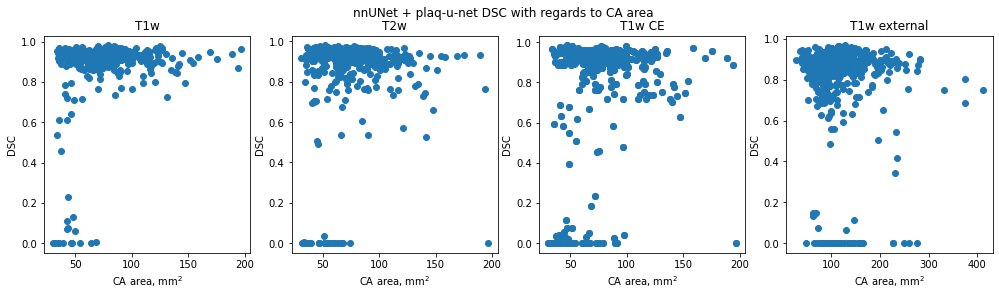

In [159]:
areas_test, diameters_test, dscs_test = get_2Dscores(scores_df_test, nifti_dirname_GT, nifti_dirname_test)
areas_t2w, diameters_t2w, dscs_t2w = get_2Dscores(scores_df_t2w, nifti_dirname_GT, nifti_dirname_t2w)
areas_t1wce, diameters_t1wce, dscs_t1wce = get_2Dscores(scores_df_t1wce, nifti_dirname_GT, nifti_dirname_t1wce)
areas_emc, diameters_emc, dscs_emc = get_2Dscores(scores_df_emc, nifti_dirname_GT_emc, nifti_dirname_emc)

plt.figure(figsize=(17, 4))
plt.subplot(141)
plt.scatter(areas_test, dscs_test)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w')
plt.subplot(142)
plt.scatter(areas_t2w, dscs_t2w)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T2w')
plt.subplot(143)
plt.scatter(areas_t1wce, dscs_t1wce)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w CE')
plt.subplot(144)
plt.scatter(areas_emc, dscs_emc)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w external')
plt.suptitle('nnUNet + plaq-u-net DSC with regards to CA area')
plt.show()

## nnUnet+plaq-u-net+ul_4

In [160]:
nifti_dirname_GT = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc_GT"

nifti_dirname_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test_plaqumap_4"
nifti_dirname_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w_plaqumap_4"
nifti_dirname_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce_plaqumap_4"
nifti_dirname_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc_plaqumap_4"

In [161]:
scores_median_test, scores_iqr_test, scores_df_test = dirname2scores(nifti_dirname_GT, nifti_dirname_test, 
                                                                     'metrics_test_plaqumap_4.csv')
scores_median_t2w, scores_iqr_t2w, scores_df_t2w = dirname2scores(nifti_dirname_GT, nifti_dirname_t2w, 
                                                                  'metrics_t2w_plaqumap_4.csv')
scores_median_t1wce, scores_iqr_t1wce, scores_df_t1wce = dirname2scores(nifti_dirname_GT, nifti_dirname_t1wce, 
                                                                        'metrics_t1wce_plaqumap_4.csv')
scores_median_emc, scores_iqr_emc, scores_df_emc = dirname2scores(nifti_dirname_GT_emc, nifti_dirname_emc, 
                                                                  'metrics_emc_plaqumap_4.csv')

Process UMCU036.nii.gz ...: : 24it [00:16,  1.45it/s]
Process UMCU036.nii.gz ...: : 24it [00:16,  1.44it/s]
Process UMCU036.nii.gz ...: : 24it [00:16,  1.47it/s]
Process EMC057.nii.gz ...: : 34it [00:24,  1.40it/s]
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [162]:
scores_df = pd.concat([scores_median_test, scores_iqr_test, 
                       scores_median_t2w, scores_iqr_t2w, 
                       scores_median_t1wce, scores_iqr_t1wce, 
                       scores_median_emc, scores_iqr_emc
                      ], axis=1)
scores_df.columns = ['test (median)', 'test (IQR)',
                     't2w (median)', 't2w (IQR)', 
                     't1wce (median)', 't1wce (IQR)', 'emc (median)', 'emc (IQR)'
                    ]
scores_df

,test (median),test (IQR),t2w (median),t2w (IQR),t1wce (median),t1wce (IQR),emc (median),emc (IQR)
dice,0.916969,0.033135,0.889351,0.047125,0.851305,0.117791,0.894002,0.067377
jaccard,0.846674,0.055896,0.800749,0.076496,0.741201,0.172934,0.808322,0.106654
precision,0.893039,0.072100,0.879915,0.112428,0.844850,0.143303,0.962945,0.057104
recall,0.912335,0.073025,0.909409,0.125806,0.861232,0.219382,0.833277,0.120914
fpr,0.000649,0.000380,0.000760,0.000664,0.000959,0.001098,0.000297,0.000381
fnr,0.087664,0.073025,0.090591,0.125806,0.138768,0.219382,0.166723,0.120914
vs,-0.012016,0.136829,-0.048403,0.195207,-0.055507,0.188741,0.147523,0.146767
hd,2.185182,2.301241,3.265370,6.088506,4.131564,6.019004,6.988188,4.629297
msd,0.190142,0.176341,0.329357,0.224724,0.489317,0.594719,0.464929,0.322643
mdsd,0.000000,0.000000,0.000000,0.000000,0.000000,0.303026,0.273445,0.273449


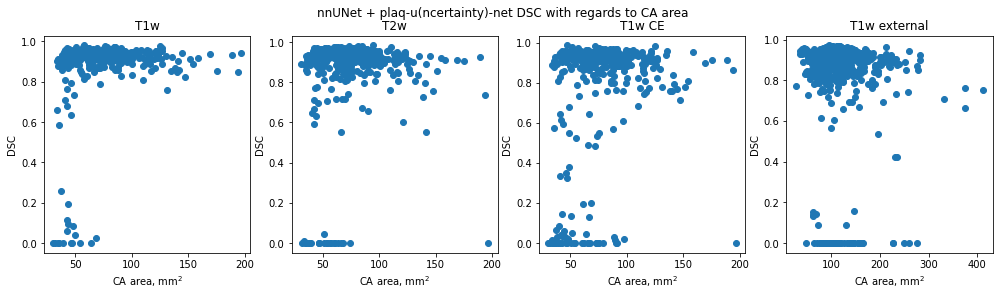

In [163]:
areas_test, diameters_test, dscs_test = get_2Dscores(scores_df_test, nifti_dirname_GT, nifti_dirname_test)
areas_t2w, diameters_t2w, dscs_t2w = get_2Dscores(scores_df_t2w, nifti_dirname_GT, nifti_dirname_t2w)
areas_t1wce, diameters_t1wce, dscs_t1wce = get_2Dscores(scores_df_t1wce, nifti_dirname_GT, nifti_dirname_t1wce)
areas_emc, diameters_emc, dscs_emc = get_2Dscores(scores_df_emc, nifti_dirname_GT_emc, nifti_dirname_emc)

plt.figure(figsize=(17, 4))
plt.subplot(141)
plt.scatter(areas_test, dscs_test)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w')
plt.subplot(142)
plt.scatter(areas_t2w, dscs_t2w)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T2w')
plt.subplot(143)
plt.scatter(areas_t1wce, dscs_t1wce)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w CE')
plt.subplot(144)
plt.scatter(areas_emc, dscs_emc)
plt.xlabel('CA area, mm$^{2}$')
plt.ylabel('DSC')
plt.title('T1w external')
plt.suptitle('nnUNet + plaq-u(ncertainty)-net DSC with regards to CA area')
plt.show()